In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
loan = pd.read_csv("loan.csv")
 
print("Original shape of loan DataFrame:", loan.shape)
 
# Drop Loan_ID column
loan = loan.drop('Loan_ID', axis=1)
 
# Remove rows with missing Credit_History
loan = loan.dropna(subset=['Credit_History'])
 
print("Shape of loan DataFrame after dropping Loan_ID and rows with missing Credit_History:", loan.shape)
 
print("Shape of loan DataFrame before processing Dependents column:", loan.shape)
 
# Impute missing values in Dependents with mode before converting type
if loan['Dependents'].isnull().any():
    loan['Dependents'] = loan['Dependents'].fillna(loan['Dependents'].mode()[0])
    print("Missing values in Dependents imputed with mode.")
 
loan['Dependents'] = loan['Dependents'].replace('3+', '3')
loan['Dependents'] = loan['Dependents'].astype(int)
print("Dependents column processed.")
 
# Impute missing categorical values with mode
for col in ['Gender', 'Self_Employed', 'Loan_Amount_Term']:
    if col in loan.columns and loan[col].isnull().any(): # Check if column exists and has NaNs
        loan[col] = loan[col].fillna(loan[col].mode()[0])
        print(f"Missing values in {col} imputed with mode.")
 
# Impute missing numerical value (LoanAmount) with median
if loan['LoanAmount'].isnull().any():
    loan['LoanAmount'] = loan['LoanAmount'].fillna(loan['LoanAmount'].median())
    print("Missing values in LoanAmount imputed with median.")
 
# One-hot encode remaining categorical columns
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
print(f"Categorical columns to be one-hot encoded: {categorical_cols}")
loan = pd.get_dummies(loan, columns=categorical_cols, drop_first=True)
print("Categorical columns one-hot encoded.")
 
print("Shape of loan DataFrame after imputation and one-hot encoding:", loan.shape)
print("\nVerifying no remaining missing values:")
print(loan.isna().sum())

Original shape of loan DataFrame: (367, 12)
Shape of loan DataFrame after dropping Loan_ID and rows with missing Credit_History: (338, 11)
Shape of loan DataFrame before processing Dependents column: (338, 11)
Missing values in Dependents imputed with mode.
Dependents column processed.
Missing values in Gender imputed with mode.
Missing values in Self_Employed imputed with mode.
Missing values in Loan_Amount_Term imputed with mode.
Missing values in LoanAmount imputed with median.
Categorical columns to be one-hot encoded: ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
Categorical columns one-hot encoded.
Shape of loan DataFrame after imputation and one-hot encoding: (338, 12)

Verifying no remaining missing values:
Dependents                 0
ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Credit_History             0
Gender_Male                0
Married_Yes                0
Education_Not Gradua

In [4]:
y_loan = loan['Credit_History']
X_loan = loan.drop('Credit_History', axis=1)
 
X_loan_train, X_loan_test, y_loan_train, y_loan_test = train_test_split(X_loan, y_loan, test_size=0.2, random_state=42)
 
numerical_features = ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
 
scaler = StandardScaler()
 
X_loan_train[numerical_features] = scaler.fit_transform(X_loan_train[numerical_features])
X_loan_test[numerical_features] = scaler.transform(X_loan_test[numerical_features])

In [5]:
loan_base_models = [
    ('lr', LogisticRegression(random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=3, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]
 
loan_meta_model = LogisticRegression(random_state=42)
 
loan_classifier = StackingClassifier(
    estimators=loan_base_models,
    final_estimator=loan_meta_model,
    cv=5
)

In [6]:
loan_classifier.fit(X_loan_train, y_loan_train)

,estimators,"[('lr', ...), ('dt', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


Loan Prediction Accuracy Score: 0.8235294117647058


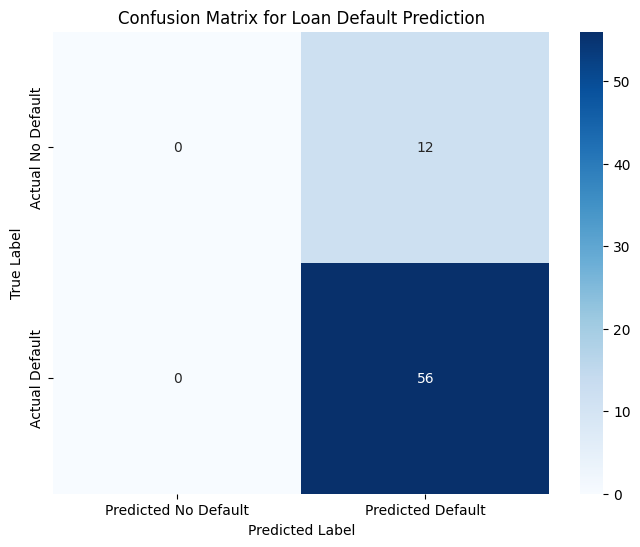

In [7]:
y_loan_pred = loan_classifier.predict(X_loan_test)
 
print("Loan Prediction Accuracy Score:", accuracy_score(y_loan_test, y_loan_pred))
 
cm = confusion_matrix(y_loan_test, y_loan_pred)
 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Default', 'Predicted Default'],
            yticklabels=['Actual No Default', 'Actual Default'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Loan Default Prediction')
plt.show()